In [0]:

import os
import kagglehub
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report
from pyspark.sql.functions import datediff, col
from pyspark.sql.functions import col, explode_outer, lpad, regexp_replace
from pyspark.sql import DataFrame, SparkSession
from pyspark.sql.functions import posexplode, concat, lit
import seaborn as sns


# Display all columns
pd.set_option('display.max_columns', None)

os.environ['KAGGLEHUB_CACHE'] = '/Volumes/workspace/gjain/project_health'
path = kagglehub.dataset_download("bonifacechosen/nhis-healthcare-claims-and-fraud-dataset")
print(path)

/Volumes/workspace/gjain/project_health/datasets/bonifacechosen/nhis-healthcare-claims-and-fraud-dataset/versions/3


In [0]:
# read into a dataframe
raw = spark.read.csv("/Volumes/workspace/gjain/project_health/datasets/bonifacechosen/nhis-healthcare-claims-and-fraud-dataset/versions/3/simulated_healthcare_claims (1).csv", header=True, inferSchema=True).withColumnRenamed("Amount Billed", "paid_amt").withColumnRenamed("Fraud Type", "fraud").withColumnRenamed("Date Admitted", "admission_dt").withColumnRenamed("Date Discharged", "discharge_dt").withColumnRenamed("Patient ID", "patient_id").withColumnRenamed("Age", "age").withColumnRenamed("Gender", "gender")
display(raw)

patient_id,age,gender,admission_dt,discharge_dt,Diagnosis,paid_amt,fraud
8ab36085-4870-4f1b-a4be-582d63fd8c3d,4,Female,2023-05-17,2023-05-20,Cataract Surgery,87417.22,No Fraud
9fb5317c-d41e-4d4d-9425-c377cd8a3e52,87,Male,2024-05-14,2024-05-14,Hypertension,960571.45,Phantom Billing
577d1463-80cd-4b33-8de0-83a6209934de,30,Male,2023-02-12,2023-02-22,Migraine,151758.91,No Fraud
b40a9c68-a4a9-472e-98af-c42427a27fc0,58,Female,2022-01-14,2022-01-16,Gastroenteritis,127758.53,No Fraud
4100caf4-2abd-473e-8703-6e46372ef9cb,20,Male,2023-11-21,2023-11-22,Pregnancy,48083.36,No Fraud
5eeb331c-9423-47db-bdf9-fe38f4390e2a,46,Female,2023-06-26,2023-06-26,Routine Check-up,48079.01,No Fraud
63128ad8-2ecf-4818-87fb-2a6683aafcac,49,Male,2023-08-24,2023-09-03,Diabetes,30455.05,No Fraud
04f68943-edef-4683-a4af-df454db642cc,47,Male,2022-05-23,2022-05-23,Pregnancy,175911.71,Wrong Diagnoses
9f63ad7a-4597-4309-8baa-a3ea6b4f8709,99,Female,2022-06-13,2022-06-16,Pregnancy,128200.7,No Fraud
e171f974-88d9-4788-8c78-4dcf7cf36b15,59,Female,2022-11-30,2022-12-05,Cesarean Section,147453.06,No Fraud


In [0]:
# Example: Create age feature
df = raw.toPandas()
df['admission_dt'] = pd.to_datetime(df['admission_dt'])
df['discharge_dt'] = pd.to_datetime(df['discharge_dt']) 

print("Number of null ptnt_age values:", df['age'].isnull().sum())

# Feature engineering: use primary diagnosis/procedure codes, gender, LOS, etc.
df['length_of_stay'] = (df['discharge_dt'] - df['admission_dt']).dt.days.astype('int') 
print("Number of null length_of_stay values:", df['length_of_stay'].isnull().sum())
print(f"Maximum value in column {'length_of_stay'}: {df['length_of_stay'].max()}")
print(f"Minimum value in column {'length_of_stay'}: {df['length_of_stay'].min()}")

# # Label encoding for categorical features
#cat_cols = ['gender']
#for col in cat_cols:
#    df[col] = LabelEncoder().fit_transform(df[col])

Number of null ptnt_age values: 0
Number of null length_of_stay values: 0
Maximum value in column length_of_stay: 10
Minimum value in column length_of_stay: 0


In [0]:
# def find_outliers(df, column, by='age_group'):
#     print(f"Outliers in {column} by {by}:")
#     for gender in df[by].unique():
#         vals = df[df[by] == gender][column]
#         q1 = vals.quantile(0.25)
#         q3 = vals.quantile(0.75)
#         iqr = q3 - q1
#         lower = q1 - 1.5 * iqr
#         upper = q1 + 1.5 * iqr
#         outliers = df[(df[by] == gender) & ((df[column] < lower) | (df[column] > upper))]
#         print(f"counts of outliers in {gender} in {column}: {len(outliers)}")

# # Check for outliers in length_of_stay
# find_outliers(df, 'length_of_stay', by='age_group')

Outliers in length_of_stay by age_group:


---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
File /databricks/python/lib/python3.12/site-packages/pandas/core/indexes/base.py:3805, in Index.get_loc(self, key)
   3804 try:
-> 3805     return self._engine.get_loc(casted_key)
   3806 except KeyError as err:

File index.pyx:167, in pandas._libs.index.IndexEngine.get_loc()

File index.pyx:196, in pandas._libs.index.IndexEngine.get_loc()

File pandas/_libs/hashtable_class_helper.pxi:7081, in pandas._libs.hashtable.PyObjectHashTable.get_item()

File pandas/_libs/hashtable_class_helper.pxi:7089, in pandas._libs.hashtable.PyObjectHashTable.get_item()

KeyError: 'age_group'

The above exception was the direct cause of the following exception:

KeyError                                  Traceback (most recent call last)
File <command-6740047927986976>, line 14
     11         print(f"counts of outliers in {gender} in {column}: {len(outliers

Summary statistics by age_group:
          length_of_stay             
                    mean median count
age_group                            
0-17            5.070681    5.0  3438
18-29           4.989474    5.0  2375
30-44           5.082722    5.0  2998
45-59           5.019048    5.0  2940
60-74           5.076923    5.0  3016
75+             4.993058    5.0  5042


/home/spark-2bb9f162-2294-440d-bb49-83/.ipykernel/3457/command-6740047927986975-2195232266:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df.groupby('age_group')[['length_of_stay']].agg(['mean', 'median', 'count'])


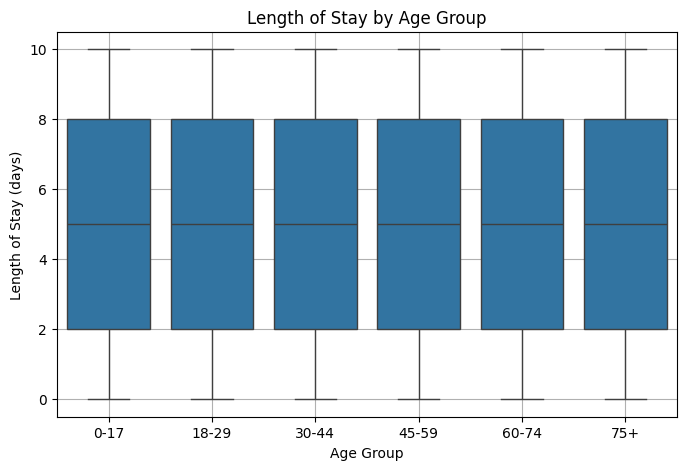

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

# Create age buckets
age_bins = [0, 18, 30, 45, 60, 75, 100]
age_labels = ['0-17', '18-29', '30-44', '45-59', '60-74', '75+']
df['age_group'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, right=False)

# Group by age_group and get statistics
summary = df.groupby('age_group')[['length_of_stay']].agg(['mean', 'median', 'count'])
print("Summary statistics by age_group:")
print(summary)

# Boxplot of LOS by age group
plt.figure(figsize=(8,5))
sns.boxplot(x='age_group', y='length_of_stay', data=df)
plt.title("Length of Stay by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Length of Stay (days)")
plt.grid(True)
plt.show()